# **Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf
import numpy as np

# **Read the input file**
And if there are 2 values listed, we'll convert it into mono signal by applying the mean.

In [2]:
filename = 'medicare (3).wav'
def _read_wav(wave_file):
	# Read the input
	rate, data = wf.read(wave_file)
	channels = len(data.shape)
	filename = wave_file

	# Convert to mono
	if channels == 2 :
		data = np.mean(data, axis=1, dtype=data.dtype)
		channels = 1
	return rate , data
  

rate , data = _read_wav(filename)

# **Ploting the signal**
Ploting the signal in order to see the regions detected here.

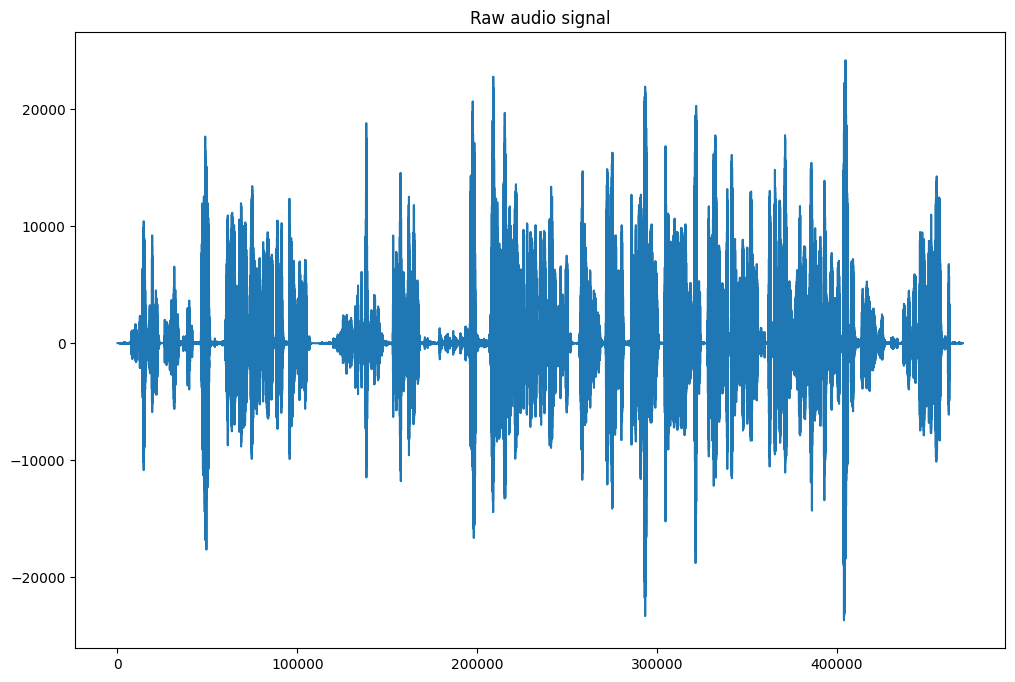

In [3]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(data)), data)
plt.title("Raw audio signal")
plt.show()

# **Rolling Window**
We will determine the energy in the frequency range that usually is associated to speech, and the energy of the whole band. If the ratio is larger than a threshold, we can assume that someone is speaking.
Here’s what the constants are used for:


*   SAMPLE_START : the start index,
*   SPEECH_START_BAND : the minimum frequency of a human voice
*   SPEECH_END_BAND : the maximum frequency of a human voice
*   SAMPLE_WINDOW : a 20 ms window size on which we run the algorithm
*   SAMPLE_OVERLAP : the amount by which we shift the window size at each step
*   THRESHOLD : the threshold for the energy ratio under which a sound is not tagged as a voice

In [ ]:
SAMPLE_START = 0
SPEECH_START_BAND = 300
SPEECH_END_BAND = 3000
SAMPLE_WINDOW = 50
SAMPLE_OVERLAP = 25
THRESHOLD = 0.6

In [ ]:
while (SAMPLE_START < (len(data) - SAMPLE_WINDOW)):
    
    # Select only the region of the data in the window
    SAMPLE_END = SAMPLE_START + SAMPLE_WINDOW
    if SAMPLE_END >= len(data): 
        SAMPLE_END = len(data)-1

    data_window = data[SAMPLE_START:SAMPLE_END]
    # Detect speech here
    # Increment 
    SAMPLE_START += SAMPLE_OVERLAP

# **Speech Ratio**
To determine the voice energy, we will only consider frequencies between 300 and 3’000 Hz, as they correspond to human voice frequencies.

In [ ]:
def _calculate_frequencies(audio_data):
    data_freq = np.fft.fftfreq(len(audio_data),1.0/rate)
    data_freq = data_freq[1:]
    return data_freq

# **Fast Fourrier Transform**
This will return regular values between -8’000 and 8’000. The energy transported by a wave is directly proportional to the square of the amplitude of the wave, which can be computed using a Fast Fourrier Transform.

In [ ]:
def _calculate_energy(audio_data):
    data_ampl = np.abs(np.fft.fft(audio_data))
    data_ampl = data_ampl[1:]
    return data_ampl ** 2

# **Connecting Energies**
We connect the energy with the frequency by creating a dictionary whose keys are the absolute value of the frequency, and values are the corresponding energy at that frequency.


In [ ]:
def _connect_energy_with_frequencies(data):
    
    data_freq = _calculate_frequencies(data)
    data_energy = _calculate_energy(data)
    
    energy_freq = {}
    for (i, freq) in enumerate(data_freq):
        if abs(freq) not in energy_freq:
            energy_freq[abs(freq)] = data_energy[i] * 2
    return energy_freq

energy_freq = _connect_energy_with_frequencies(data)
sum_full_energy = sum(energy_freq.values())


# **Sum Energies**
we suppose that a human voice will be anywhere between 300 and 3’000 Hz. Therefore, we sum the energy corresponding such frequencies in the time window, and we can compare it with the full sum of energies.

In [ ]:
def _sum_energy_in_band(energy_frequencies):
    sum_energy = 0
    for f in energy_frequencies.keys():
        if SPEECH_START_BAND < f < SPEECH_END_BAND:
            sum_energy += energy_frequencies[f]
    return sum_energy

# **Defining Speech Ratio**
we can define the speech ratio as being the quotien between the sum of the speech energy in the time window and the sum of the total energy.

In [ ]:
speech_ratio = sum_voice_energy/sum_full_energy
speech_ratio

# **Combining LOOP & SPEECH RATIO**
So far, we estimated the speech ratio on the whole audio file, without using a rolling window. It is now time to combine both approaches. We will store in speech_ratio_list a list of all the speech ratios in the loop.

In [ ]:
speech_ratio_list = []
detected_voice = []
mean_data = []

SAMPLE_START = 0

while (SAMPLE_START < (len(data) - SAMPLE_WINDOW)):
    
    # Select only the region of the data in the window
    SAMPLE_END = SAMPLE_START + SAMPLE_WINDOW
    if SAMPLE_END >= len(data): 
        SAMPLE_END = len(data)-1

    data_window = data[SAMPLE_START:SAMPLE_END]
    mean_data.append(np.mean(data_window))

    # Full energy
    energy_freq = _connect_energy_with_frequencies(data_window)
    sum_full_energy = sum(energy_freq.values())
    
    # Voice energy
    sum_voice_energy = _sum_energy_in_band(energy_freq)
    
    # Speech ratio
    speech_ratio = sum_voice_energy/sum_full_energy
    speech_ratio_list.append(speech_ratio)
    detected_voice.append(speech_ratio > THRESHOLD)
    
    # Increment 
    SAMPLE_START += SAMPLE_OVERLAP

<ipython-input-37-52bac466b760>:25: RuntimeWarning: invalid value encountered in double_scalars
  speech_ratio = sum_voice_energy/sum_full_energy


# **Combining Speech Ratio List with the threshold over time**

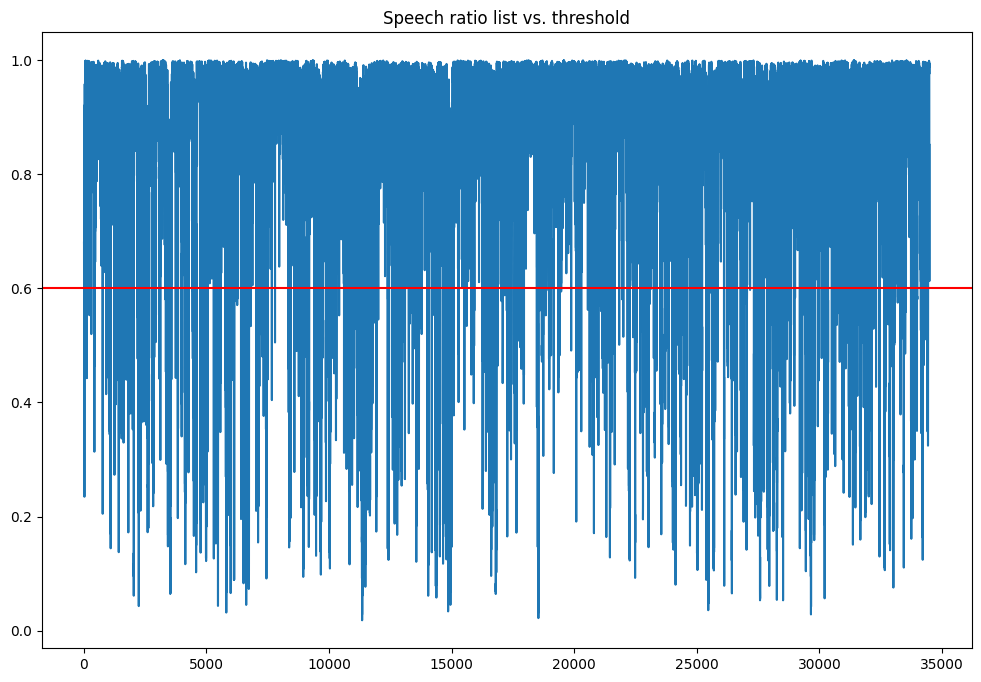

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(speech_ratio_list)
plt.axhline(THRESHOLD, c='r')
plt.title("Speech ratio list vs. threshold")
plt.show()

# **comparing the raw signal with moments we detected a voice**

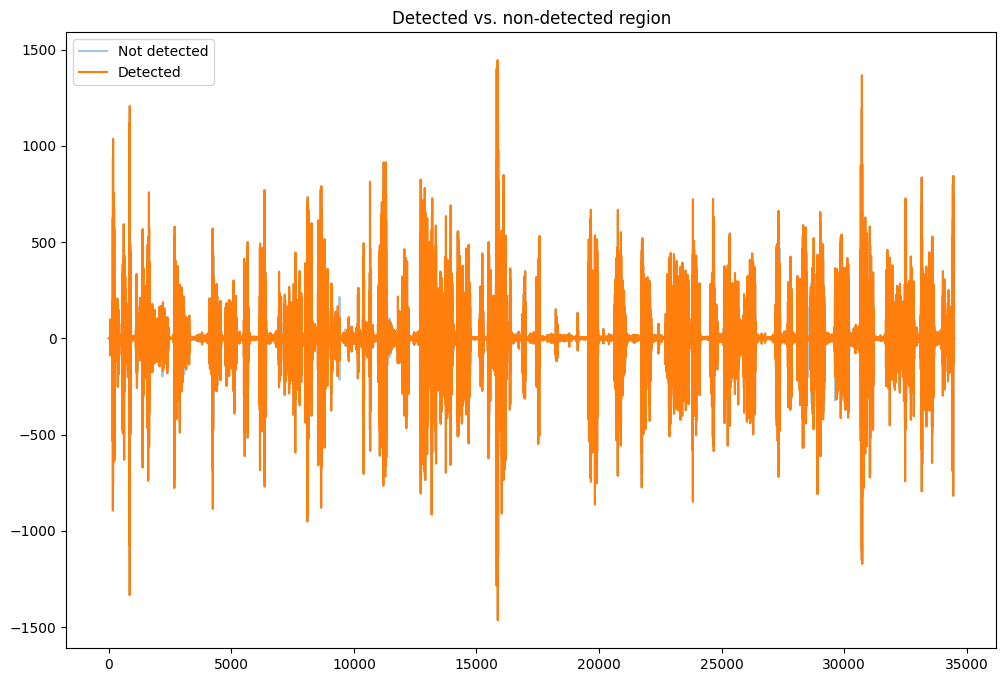

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.array(mean_data), alpha=0.4, label="Not detected")
plt.plot(np.array(detected_voice) * np.array(mean_data), label="Detected")
plt.legend()
plt.title("Detected vs. non-detected region")
plt.show()

# **Smoothing the regions**
The output is interesting but would require some smoothing if we want to detect smooth regions in which a user speaks. We’ll go for a median filter and apply it on the speech ratio’s list.

In [ ]:
def _median_filter (x, k):
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median(y, axis=1)

**Apply it to the Region**

In [ ]:
SPEECH_WINDOW = 0.5

def _smooth_speech_detection(detected_voice):
    window = 0.02
    median_window=int(SPEECH_WINDOW/window)
    if median_window % 2 == 0 : 
        median_window = median_window - 1
    median_energy = _median_filter(detected_voice, median_window)
    
    return median_energy

**Apply this to the pipeline**

In [ ]:
speech_ratio_list = []
detected_voice = []
mean_data = []

SAMPLE_START = 0

while (SAMPLE_START < (len(data) - SAMPLE_WINDOW)):
    
    # Select only the region of the data in the window
    SAMPLE_END = SAMPLE_START + SAMPLE_WINDOW
    if SAMPLE_END >= len(data): 
        SAMPLE_END = len(data)-1
    data_window = data[SAMPLE_START:SAMPLE_END]
    mean_data.append(np.mean(data_window))
    # Full energy
    energy_freq = _connect_energy_with_frequencies(data_window)
    sum_full_energy = sum(energy_freq.values())
    
    # Voice energy
    sum_voice_energy = _sum_energy_in_band(energy_freq)
    
    # Speech ratio
    speech_ratio = sum_voice_energy/sum_full_energy
    speech_ratio_list.append(speech_ratio)
    detected_voice.append(int(speech_ratio > THRESHOLD))
    
    # Increment 
    SAMPLE_START += SAMPLE_OVERLAP
    
detected_voice = _smooth_speech_detection(np.array(detected_voice))

<ipython-input-42-6f22c4f25253>:23: RuntimeWarning: invalid value encountered in double_scalars
  speech_ratio = sum_voice_energy/sum_full_energy


**Ploting the Detected Regions**

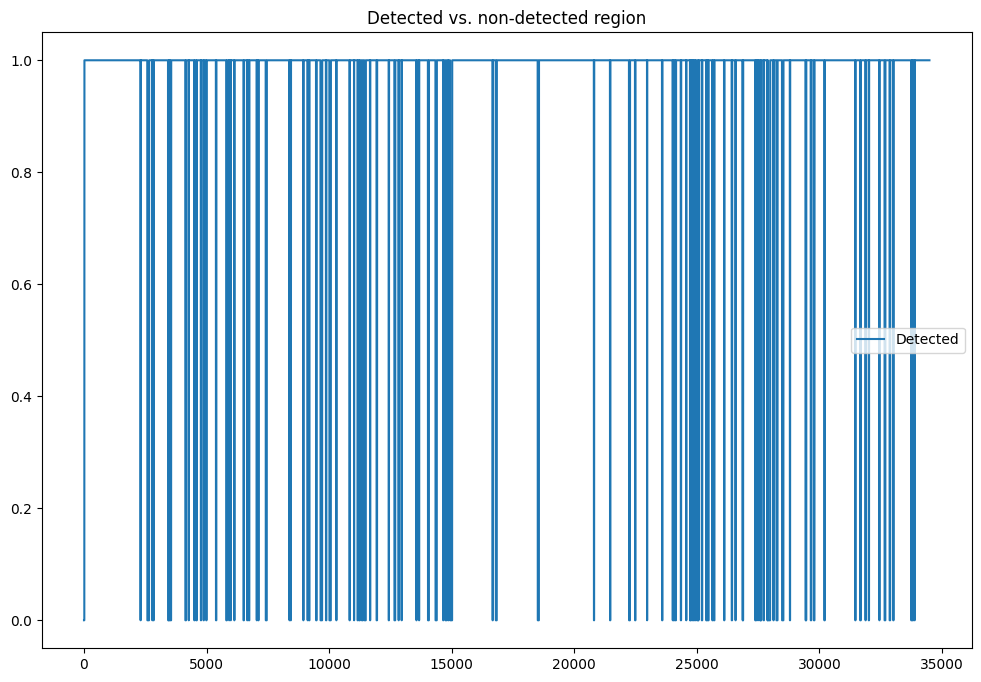

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.array(detected_voice), label="Detected")
plt.legend()
plt.title("Detected vs. non-detected region")
plt.show()

**We can plot once again the regions on the raw signal in which the voice has been detected**

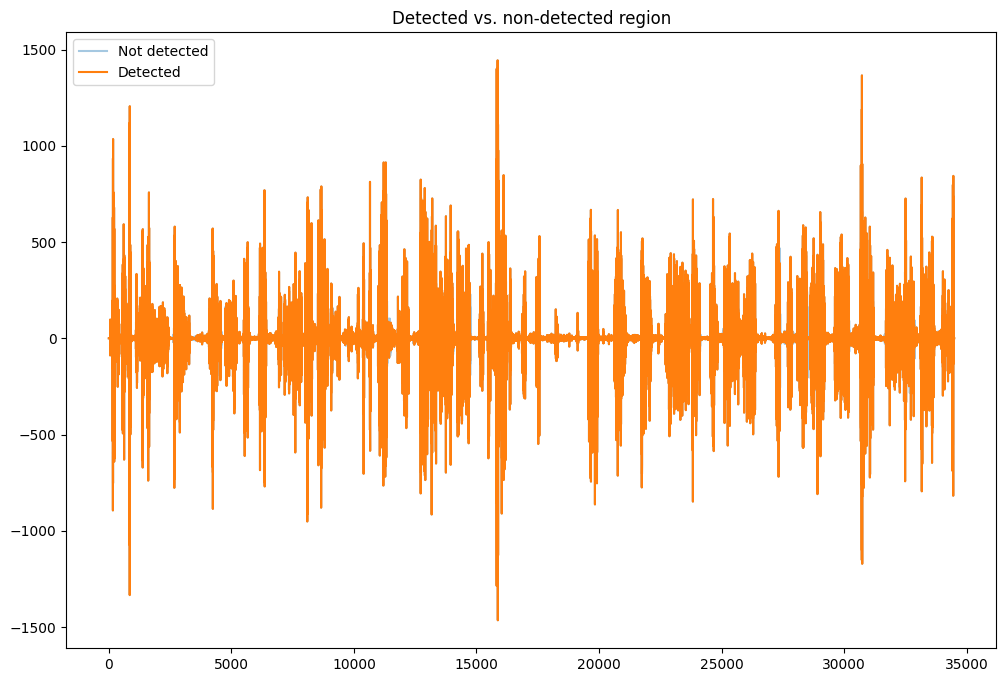

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.array(mean_data), alpha=0.4, label="Not detected")
plt.plot(np.array(detected_voice) * np.array(mean_data), label="Detected")
plt.legend()
plt.title("Detected vs. non-detected region")
plt.show()